In [40]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pandas as pd
import numpy as np
import os
from pyspark.sql.functions import col,lit,count, when,desc
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml.regression import LinearRegression,GBTRegressor, RandomForestRegressor, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from autofeat import AutoFeatRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time
from pyspark.sql.window import Window
from pyspark.sql.functions import percentile_approx
from pyspark.sql.types import DoubleType,BooleanType,StringType,ArrayType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



In [2]:
spark = SparkSession.builder \
    .appName("airbnb app suggestion") \
    .config("spark.jars", "./lib/postgresql-42.7.3.jar") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
    
jdbc_url = "jdbc:postgresql://localhost:5432/airbnb_db"

connection_props = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver"
}
df_listing = spark.read.jdbc(jdbc_url, "listings", properties=connection_props)
df_listing.printSchema()



root
 |-- row_id: long (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- host_has_profile: boolean (nullable = true)
 |-- host_verifications: boolean (nullable = true)
 |-- host_is_superhost: boolean (nullable = true)
 |-- host_since: date (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bedrooms: decimal(38,18) (nullable = true)
 |-- beds: decimal(38,18) (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- maximum_nights: integer (nullable = true)
 |-- has_availability: boolean (nullable = true)
 |-- availability_30: integer (nullable = true)
 |-- availability_60: integer (nullable = true)
 |-- availability_90: integer (nullable

In [4]:

decimal_cols = [col.name for col in df_listing.schema.fields if str(col.dataType) in ['DecimalType(38,18)', 'FloatType()','DoubleType()']]

for col_name in decimal_cols:
    df_listing = df_listing.withColumn(col_name, df_listing[col_name].cast(DoubleType()))
    
boolean_cols = [f.name for f in df_listing.schema.fields if isinstance(f.dataType, BooleanType)]

for col_name in boolean_cols:
    df_listing = df_listing.withColumn(col_name, when(col(col_name) == True, 1).otherwise(0))

In [5]:
df_listing.show(5)

+------+----------------------+----------------+------------------+-----------------+----------+------------------+------------------+------------------------------+------------------+---------------+------------+--------+----+-------------------+--------------+--------------+----------------+---------------+---------------+---------------+----------------+-----------------+-----------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+--------------------+-----+
|row_id|neighbourhood_cleansed|host_has_profile|host_verifications|host_is_superhost|host_since|host_response_time|host_response_rate|calculated_host_listings_count|     property_type|      room_type|accommodates|bedrooms|beds|cancellation_policy|minimum_nights|maximum_nights|has_availability|availability_30|availability_60|availability_90|availability_365|number_of_reviews|reviews_per_

In [6]:
total_rows = df_listing.count()

nulls_df = df_listing.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_listing.columns
])

nulls_summary = nulls_df.selectExpr(
    "stack({0}, {1}) as (column, null_count)".format(
        len(df_listing.columns),
        ", ".join([f"'{c}', `{c}`" for c in df_listing.columns])
    )
).withColumn("null_pct", (col("null_count") / total_rows) * 100)

nulls_summary.orderBy(col("null_pct").desc()).show(truncate=False)


+---------------------------+----------+--------------------+
|column                     |null_count|null_pct            |
+---------------------------+----------+--------------------+
|cancellation_policy        |91031     |100.0               |
|host_response_rate         |38821     |42.645911832232976  |
|beds                       |31087     |34.14990497742527   |
|price                      |30938     |33.98622447298173   |
|review_scores_value        |23875     |26.22732915160769   |
|review_scores_checkin      |23874     |26.22623062473223   |
|review_scores_location     |23873     |26.225132097856772  |
|review_scores_accuracy     |23867     |26.21854093660401   |
|review_scores_communication|23865     |26.216343882853092  |
|review_scores_cleanliness  |23864     |26.215245355977636  |
|reviews_per_month          |23855     |26.205358614098493  |
|first_review               |23855     |26.205358614098493  |
|last_review                |23855     |26.205358614098493  |
|review_

In [8]:

df_listing = df_listing.drop("cancellation_policy")


cols_median = ["beds", "bedrooms", "reviews_per_month", "review_scores_value",
               "review_scores_checkin", "review_scores_location", "review_scores_accuracy",
               "review_scores_communication", "review_scores_cleanliness", "review_scores_rating"]

for col_name in cols_median:
    median_val = df_listing.approxQuantile(col_name, [0.5], 0.01)[0]
    df_listing = df_listing.fillna({col_name: median_val})
    
    
min_date = df_listing.selectExpr("min(first_review)").first()[0]
min_date_str = str(min_date)

df_listing = df_listing.fillna({
    "first_review": min_date_str,
    "last_review": min_date_str
})


def impute_with_mode(df, col_names):
    for col_name in col_names:
        non_null_df = df.filter(col(col_name).isNotNull())
        mode_row = (
            non_null_df.groupBy(col_name)
            .count()
            .orderBy(desc("count"))
            .first()
        )

        if mode_row:
            mode_val = mode_row[0]
            if hasattr(mode_val, '__str__'):
                mode_val = str(mode_val)
            df = df.fillna({col_name: mode_val})
    
    return df


cat_cols = ["host_response_time", "host_response_rate", "has_availability"]
df_listing = impute_with_mode(df_listing, cat_cols)


median_price_per_group = df_listing.groupBy("neighbourhood_cleansed", "room_type").agg(
    percentile_approx("price", 0.5, 100).alias("median_price")
)


df_with_median = df_listing.join(
    median_price_per_group,
    on=["neighbourhood_cleansed", "room_type"],
    how="left"
)

df_listing = df_with_median.withColumn(
    "price",
    when(col("price").isNull(), col("median_price")).otherwise(col("price"))
).drop("median_price")

In [9]:
from pyspark.sql.functions import current_date, datediff

## Convert date to number of days till today
df_listing = df_listing.withColumn(
    "host_since_days",
    datediff(current_date(), col("host_since"))
)


In [9]:
df_listing = df_listing.withColumn(
    "host_response_time",
    when(
        (col("host_response_time").isNull()) | (col("host_response_time") == "N/A"),
        "a few days or more"
    ).otherwise(col("host_response_time"))
)

In [10]:
from pyspark.sql.functions import explode

amenities_exploded = df_listing.select(explode(col("amenities")).alias("amenity"))

#les 50 équipements les plus fréquents
top_50_amenities = amenities_exploded.groupBy("amenity") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(50)

top_amenities_list = [row["amenity"] for row in top_50_amenities.collect()]

top_amenities_list

['Kitchen',
 'Wifi',
 'Smoke alarm',
 'Essentials',
 'Hot water',
 'Hair dryer',
 'Iron',
 'Washer',
 'Dishes and silverware',
 'Hangers',
 'Bed linens',
 'Cooking basics',
 'Refrigerator',
 'Heating',
 'TV',
 'Microwave',
 'Shampoo',
 'Hot water kettle',
 'Dedicated workspace',
 'Cleaning products',
 'Wine glasses',
 'Oven',
 'Baking sheet',
 'Toaster',
 'Dishwasher',
 'Freezer',
 'Shower gel',
 'Dining table',
 'Coffee maker',
 'Elevator',
 'Drying rack for clothing',
 'Body soap',
 'Coffee',
 'Carbon monoxide alarm',
 'Extra pillows and blankets',
 'Self check-in',
 'Long term stays allowed',
 'Room-darkening shades',
 'Host greets you',
 'Stove',
 'Books and reading material',
 'Bathtub',
 'Lockbox',
 'Portable fans',
 'Laundromat nearby',
 'First aid kit',
 'Clothing storage',
 'Central heating',
 'Private entrance',
 'Luggage dropoff allowed']

In [11]:
from pyspark.sql.functions import array_contains

for amenity in top_amenities_list:
    safe_col_name = amenity.strip().lower().replace(" ", "_").replace("-", "_").replace("/", "_")
    df_listing = df_listing.withColumn(
        f"amenity_{safe_col_name}",
        array_contains(col("amenities"), amenity).cast("integer")
    )

In [12]:
#conversion du prix en euro
exchange_rate = 0.85  # 1 USD = 0.85 EUR 
df_listing = df_listing.withColumn("price_euro", col("price") * exchange_rate)



In [13]:
df_listing.show(5)

+----------------------+-----------+------+----------------+------------------+-----------------+----------+------------------+------------------+------------------------------+--------------------+------------+--------+----+--------------+--------------+----------------+---------------+---------------+---------------+----------------+-----------------+-----------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+--------------------+-----+---------------+---------------+------------+-------------------+------------------+-----------------+------------------+------------+--------------+-----------------------------+---------------+------------------+----------------------+--------------------+---------------+----------+-----------------+---------------+------------------------+---------------------------+-------------------------+--------------

In [14]:
# Extraire les valeurs uniques de chaque colonne
room_type_list = df_listing.select("room_type").distinct().collect()
property_type_list = df_listing.select("property_type").distinct().collect()
host_response_time_list = df_listing.select("host_response_time").distinct().collect()
neighbourhood_list = df_listing.select("neighbourhood_cleansed").distinct().collect()



In [15]:
'''
# Créer les DataFrames en utilisant sparkContext.parallelize
room_type_rdd = spark.sparkContext.parallelize([(x,) for x in room_type_list])
property_type_rdd = spark.sparkContext.parallelize([(x,) for x in property_type_list])
host_response_time_rdd = spark.sparkContext.parallelize([(x,) for x in host_response_time_list])
neighbourhood_rdd = spark.sparkContext.parallelize([(x,) for x in neighbourhood_list])
top_amenities_rdd = spark.sparkContext.parallelize([(x,) for x in top_amenities_list])

# Définir les schémas
room_type_schema = ['room_type']
property_type_schema = ['property_type']
host_response_time_schema = ['host_response_time']
neighbourhood_schema = ['neighbourhood_cleansed']
top_amenities_schema = ['amenity']

# Créer les DataFrames avec les RDD et les schémas
room_type_df = spark.createDataFrame(room_type_rdd, room_type_schema)
property_type_df = spark.createDataFrame(property_type_rdd, property_type_schema)
host_response_time_df = spark.createDataFrame(host_response_time_rdd, host_response_time_schema)
neighbourhood_df = spark.createDataFrame(neighbourhood_rdd, neighbourhood_schema)
top_amenities_df = spark.createDataFrame(top_amenities_rdd, top_amenities_schema)
'''

"\n# Créer les DataFrames en utilisant sparkContext.parallelize\nroom_type_rdd = spark.sparkContext.parallelize([(x,) for x in room_type_list])\nproperty_type_rdd = spark.sparkContext.parallelize([(x,) for x in property_type_list])\nhost_response_time_rdd = spark.sparkContext.parallelize([(x,) for x in host_response_time_list])\nneighbourhood_rdd = spark.sparkContext.parallelize([(x,) for x in neighbourhood_list])\ntop_amenities_rdd = spark.sparkContext.parallelize([(x,) for x in top_amenities_list])\n\n# Définir les schémas\nroom_type_schema = ['room_type']\nproperty_type_schema = ['property_type']\nhost_response_time_schema = ['host_response_time']\nneighbourhood_schema = ['neighbourhood_cleansed']\ntop_amenities_schema = ['amenity']\n\n# Créer les DataFrames avec les RDD et les schémas\nroom_type_df = spark.createDataFrame(room_type_rdd, room_type_schema)\nproperty_type_df = spark.createDataFrame(property_type_rdd, property_type_schema)\nhost_response_time_df = spark.createDataFrame

In [16]:
'''
room_type_df.write.jdbc(jdbc_url, "room_types", mode="overwrite", properties=connection_props)
property_type_df.write.jdbc(jdbc_url, "property_types", mode="overwrite", properties=connection_props)
host_response_time_df.write.jdbc(jdbc_url, "host_response_times", mode="overwrite", properties=connection_props)
neighbourhood_df.write.jdbc(jdbc_url, "neighbourhoods", mode="overwrite", properties=connection_props)
top_amenities_df.write.jdbc(jdbc_url, "amenities", mode="overwrite", properties=connection_props)
'''

'\nroom_type_df.write.jdbc(jdbc_url, "room_types", mode="overwrite", properties=connection_props)\nproperty_type_df.write.jdbc(jdbc_url, "property_types", mode="overwrite", properties=connection_props)\nhost_response_time_df.write.jdbc(jdbc_url, "host_response_times", mode="overwrite", properties=connection_props)\nneighbourhood_df.write.jdbc(jdbc_url, "neighbourhoods", mode="overwrite", properties=connection_props)\ntop_amenities_df.write.jdbc(jdbc_url, "amenities", mode="overwrite", properties=connection_props)\n'

In [15]:
neighbourhood_list = df_listing.select("neighbourhood_cleansed").distinct().collect()
neighbourhood_list

[Row(neighbourhood_cleansed='Reuilly'),
 Row(neighbourhood_cleansed='Ménilmontant'),
 Row(neighbourhood_cleansed='Opéra'),
 Row(neighbourhood_cleansed='Temple'),
 Row(neighbourhood_cleansed='Popincourt'),
 Row(neighbourhood_cleansed='Entrepôt'),
 Row(neighbourhood_cleansed='Palais-Bourbon'),
 Row(neighbourhood_cleansed='Passy'),
 Row(neighbourhood_cleansed='Buttes-Chaumont'),
 Row(neighbourhood_cleansed='Observatoire'),
 Row(neighbourhood_cleansed='Buttes-Montmartre'),
 Row(neighbourhood_cleansed='Hôtel-de-Ville'),
 Row(neighbourhood_cleansed='Élysée'),
 Row(neighbourhood_cleansed='Panthéon'),
 Row(neighbourhood_cleansed='Batignolles-Monceau'),
 Row(neighbourhood_cleansed='Luxembourg'),
 Row(neighbourhood_cleansed='Louvre'),
 Row(neighbourhood_cleansed='Bourse'),
 Row(neighbourhood_cleansed='Gobelins'),
 Row(neighbourhood_cleansed='Vaugirard')]

In [18]:
features_new_host = ["Neighbourhood Cleansed",
                   "Property Type", "Room Type", "Accommodates","Bedrooms", "Beds", "Bed Type",
                   "Minimum Nights",
                   "Price"]

features_existing_host = ["Neighbourhood Cleansed",
                          "Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type",
                          "Minimum Nights", "Availability 30", "Availability 60", "Availability 90", "Availability 365",
                          "Number of Reviews", "Reviews per Month", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness","Review Scores Checkin", "Review Scores Communication", "Review Scores Location","Review Scores Value",
                          "Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count",
                          "Price"]

In [19]:
df_listing.columns


['neighbourhood_cleansed',
 'room_type',
 'row_id',
 'host_has_profile',
 'host_verifications',
 'host_is_superhost',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'calculated_host_listings_count',
 'property_type',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'reviews_per_month',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'amenities',
 'price',
 'host_since_days',
 'amenity_kitchen',
 'amenity_wifi',
 'amenity_smoke_alarm',
 'amenity_essentials',
 'amenity_hot_water',
 'amenity_hair_dryer',
 'amenity_iron',
 'amenity_washer',
 'amenity_dishes_and_silverware',
 'amenity_hangers',
 'amenity_bed_linens',
 'amenity_cooking_basics',
 'amenit

In [16]:
plt.style.use('fivethirtyeight')

font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

In [17]:
amenities_schema = ArrayType(StringType())


def safe_cast(df, column_name, to_type):
    if to_type == FloatType():

        return when(col(column_name).cast(to_type).isNotNull(), 
                   col(column_name).cast(to_type)).otherwise(0)
    elif to_type == DateType():
        return col(column_name).cast(to_type)
    else:
        return col(column_name).cast(to_type)

## Analyse  univariée

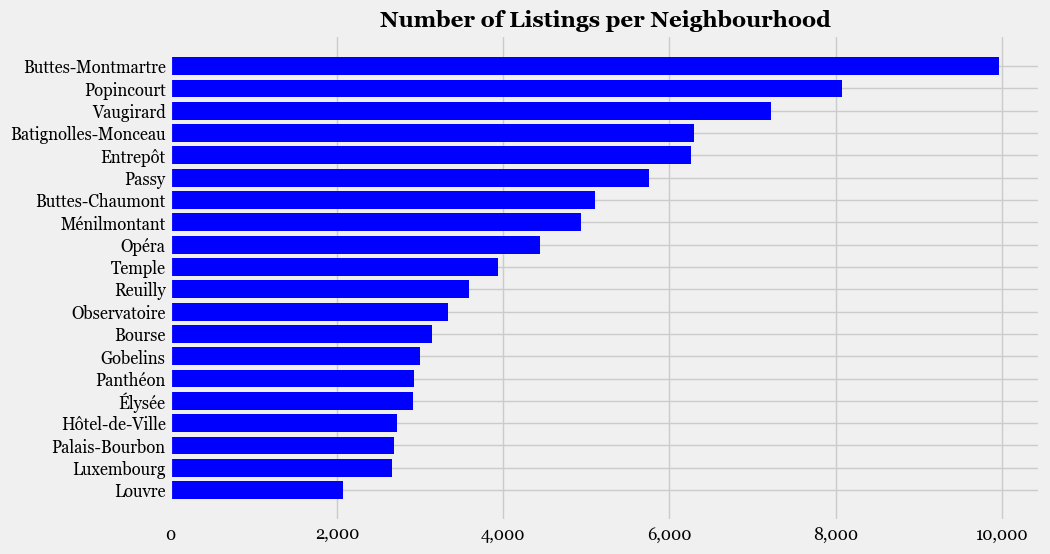

In [18]:
neighbourhood_counts = df_listing.toPandas().groupby("neighbourhood_cleansed").size().reset_index(name="listing_count")

neighbourhood_counts = neighbourhood_counts.sort_values(by="listing_count", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(neighbourhood_counts["neighbourhood_cleansed"], neighbourhood_counts["listing_count"], color='blue')
ax = plt.gca()
ax.invert_yaxis()  

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.title("Number of Listings per Neighbourhood", fontsize=16, fontweight="bold")

ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig("images_predict_price/exploratory/histograms/neighbourhood_listings.png", bbox_inches='tight')

plt.show()


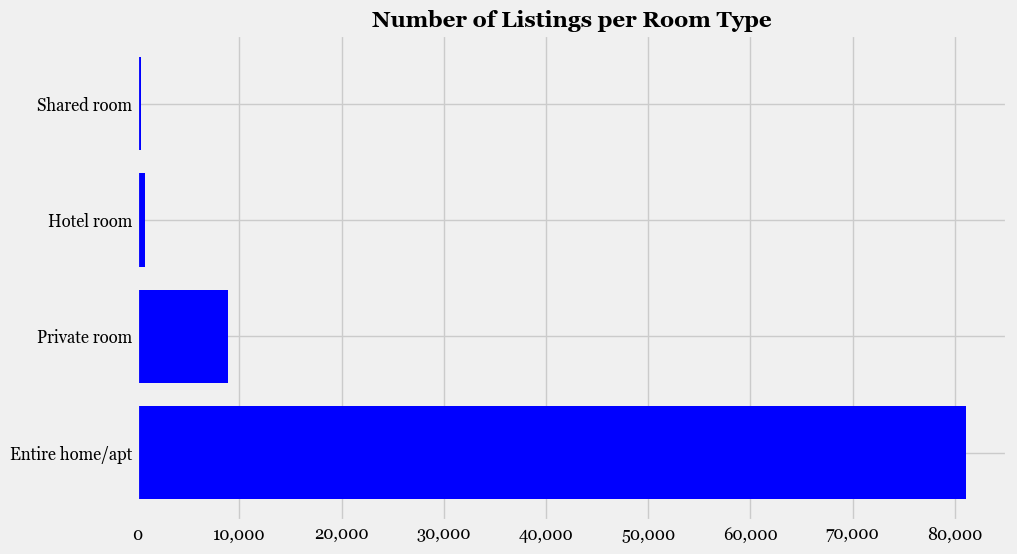

In [19]:
room_type_counts = df_listing.toPandas().groupby("room_type").size().reset_index(name="listing_count")

room_type_counts = room_type_counts.sort_values(by="listing_count", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(room_type_counts["room_type"], room_type_counts["listing_count"], color='blue')
ax = plt.gca()

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.title("Number of Listings per Room Type", fontsize=16, fontweight="bold")

ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig("images_predict_price/exploratory/histograms/room_type_listings.png", bbox_inches='tight')

plt.show()


## Analyse bivariée

C:\Users\H P\AppData\Local\Temp\ipykernel_28488\2380028638.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price', y='room_type', data=dft, order=['Entire home/apt', 'Private room', 'Shared room'],


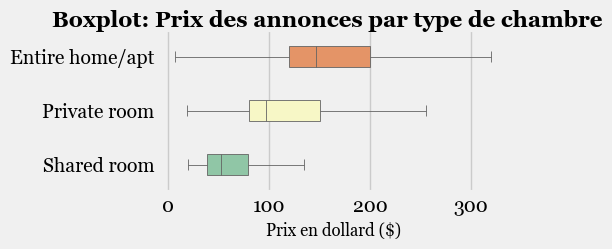

In [20]:
dft = df_listing.toPandas()[["room_type", "price"]]

plt.figure(figsize=(4, 2))
sns.boxplot(x='price', y='room_type', data=dft, order=['Entire home/apt', 'Private room', 'Shared room'],
            showfliers=False, palette="Spectral", linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Prix en dollard ($)", fontsize=12)
ax.set_ylabel("")
plt.suptitle("Boxplot: Prix des annonces par type de chambre", fontweight="bold", fontsize=16)

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/roomtype_price.png", bbox_inches='tight')

plt.show()


In [21]:
from pyspark.sql.types import NumericType

numeric_cols = [f.name for f in df_listing.schema.fields if isinstance(f.dataType, NumericType)]


C:\Users\H P\AppData\Local\Temp\ipykernel_28488\1819168660.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price', y='neighbourhood_cleansed', data=dft, order=df1["neighbourhood_cleansed"].values,


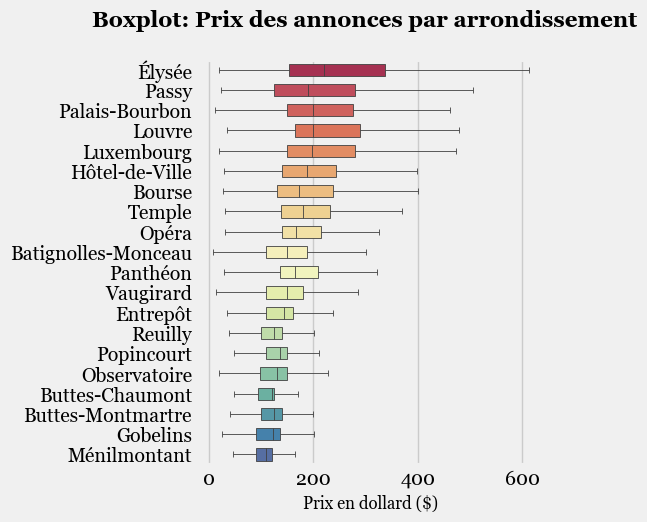

In [22]:
df1 = df_listing.toPandas().assign(price=lambda x: x["price"].astype(float))\
    .groupby("neighbourhood_cleansed").mean(numeric_only=True)["price"]\
    .reset_index().sort_values("price", ascending=False)

plt.figure(figsize=(4, 5))
dft = df_listing.toPandas()[["neighbourhood_cleansed", "price"]].copy()

sns.boxplot(x='price', y='neighbourhood_cleansed', data=dft, order=df1["neighbourhood_cleansed"].values,
            showfliers=False, palette="Spectral", linewidth=0.6, width=0.6)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Prix en dollard ($)", fontsize=12)
ax.set_ylabel("")
plt.suptitle("Boxplot: Prix des annonces par arrondissement", fontweight="bold", fontsize=16)

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/neighbourhood_price.png", bbox_inches='tight')

plt.show()


In [23]:

dfc = pd.DataFrame(df_listing.toPandas()[numeric_cols].corr(method="pearson")["price"])
dfc.reset_index(inplace=True)
dfc.columns = ["features", "correlation_with_price"]
dfc.sort_values("correlation_with_price", ascending=False)
df1 = dfc[dfc["correlation_with_price"] > 0.1]
corr_features = df1["features"].values
corr_features.tolist().append("Price")
df1

,features,correlation_with_price
5,accommodates,0.210530
6,bedrooms,0.188347
7,beds,0.207438
11,availability_30,0.119052
12,availability_60,0.122533
13,availability_90,0.123301
14,availability_365,0.134584
24,price,1.000000
76,price_euro,1.000000


<Figure size 400x500 with 0 Axes>

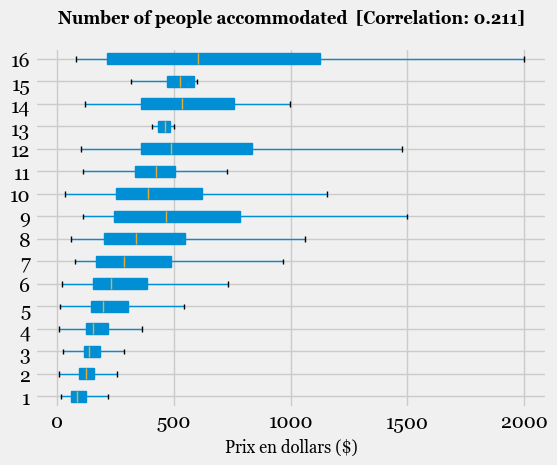

In [24]:
col = "accommodates"
plt_name = "accommodates"

cov = dfc[dfc["features"] == col]["correlation_with_price"].values
if cov.size > 0:
    cov = np.round(float(cov[0]), 3)  
else:
    cov = "N/A"

suptitle = f"Number of people accommodated  [Correlation: {cov}]"

dft = df_listing.select(col, "price").toPandas().copy()

if col not in dft.columns or "price" not in dft.columns:
    print(f"La colonne '{col}' ou 'price' n'existe pas dans le DataFrame.")
else:
    dft = dft.dropna(subset=[col, "price"])
    
    dft["price"] = dft["price"].astype(float)
    dft[col] = dft[col].astype(int)

    plt.figure(figsize=(4, 5))
    dft.boxplot(by=col, column="price", showfliers=False, vert=False, patch_artist=True)

    ax = plt.gca()
    ax.set_title("")
    ax.set_xlabel("Prix en dollars ($)", fontsize=12)
    ax.set_ylabel("")
    plt.suptitle(suptitle, fontweight="bold", fontsize=12)

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    plt.savefig(f"images_predict_price/exploratory/correlation_with_price/{plt_name}_price.png", bbox_inches='tight')
    plt.show()


<Figure size 400x500 with 0 Axes>

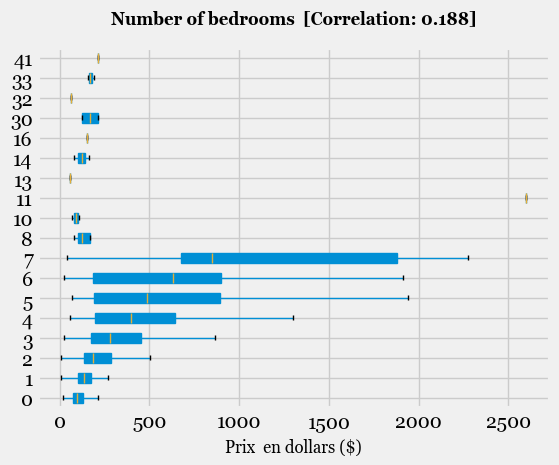

In [25]:
col = "bedrooms"
plt_name = "bedrooms"

cov = dfc[dfc["features"] == col]["correlation_with_price"].values
if cov.size > 0:
    cov = np.round(float(cov[0]), 3)  # Conversion Decimal -> float

suptitle = f"Number of bedrooms  [Correlation: {cov}]"

dft = df_listing.select(col, "price").toPandas().copy()

    
dft["price"] = dft["price"].astype(float)
dft[col] = dft[col].astype(int)

plt.figure(figsize=(4, 5))
dft.boxplot(by=col, column="price", showfliers=False, vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Prix  en dollars ($)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

plt.savefig(f"images_predict_price/exploratory/correlation_with_price/{plt_name}_price.png", bbox_inches='tight')
plt.show()


<Figure size 400x500 with 0 Axes>

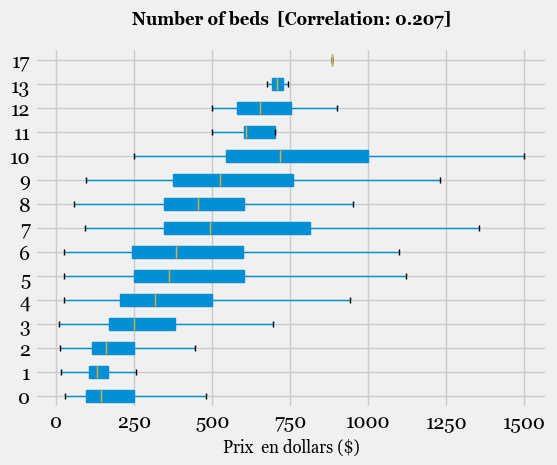

In [26]:
col = "beds"
plt_name = "beds"

cov = dfc[dfc["features"] == col]["correlation_with_price"].values
if cov.size > 0:
    cov = np.round(float(cov[0]), 3)  # Conversion Decimal -> float
else:
    cov = "N/A"

suptitle = f"Number of beds  [Correlation: {cov}]"

dft = df_listing.select(col, "price").toPandas().copy()

if col not in dft.columns or "price" not in dft.columns:
    print(f"La colonne '{col}' ou 'price' n'existe pas dans le DataFrame.")
else:
    dft = dft.dropna(subset=[col, "price"])
    
    dft["price"] = dft["price"].astype(float)
    dft[col] = dft[col].astype(int)

    plt.figure(figsize=(4, 5))
    dft.boxplot(by=col, column="price", showfliers=False, vert=False, patch_artist=True)

    ax = plt.gca()
    ax.set_title("")
    ax.set_xlabel("Prix  en dollars ($)", fontsize=12)
    ax.set_ylabel("")
    plt.suptitle(suptitle, fontweight="bold", fontsize=12)

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    plt.savefig(f"images_predict_price/exploratory/correlation_with_price/{plt_name}_price.png", bbox_inches='tight')
    plt.show()


<Figure size 400x500 with 0 Axes>

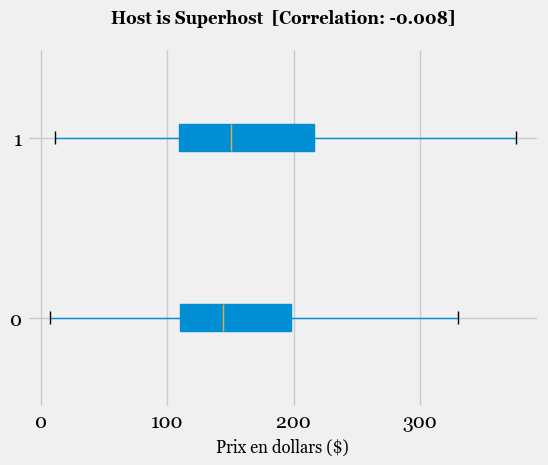

In [27]:
col = "host_is_superhost"
plt_name = "host_is_superhost"

cov = dfc[dfc["features"] == col]["correlation_with_price"].values
if cov.size > 0:
    cov = np.round(float(cov[0]), 3)  
else:
    cov = "N/A"

suptitle = f"Host is Superhost  [Correlation: {cov}]"

dft = df_listing.select(col, "price").toPandas().copy()

if col not in dft.columns or "price" not in dft.columns:
    print(f"La colonne '{col}' ou 'price' n'existe pas dans le DataFrame.")
else:
    dft = dft.dropna(subset=[col, "price"])

    dft[col] = dft[col].astype(bool).astype(int)
    dft["price"] = dft["price"].astype(float)

    plt.figure(figsize=(4, 5))
    dft.boxplot(by=col, column="price", showfliers=False, vert=False, patch_artist=True)

    ax = plt.gca()
    ax.set_title("")
    ax.set_xlabel("Prix en dollars ($)", fontsize=12)
    ax.set_ylabel("")
    plt.suptitle(suptitle, fontweight="bold", fontsize=12)

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    plt.savefig(f"images_predict_price/exploratory/correlation_with_price/{plt_name}_price.png", bbox_inches='tight')
    plt.show()


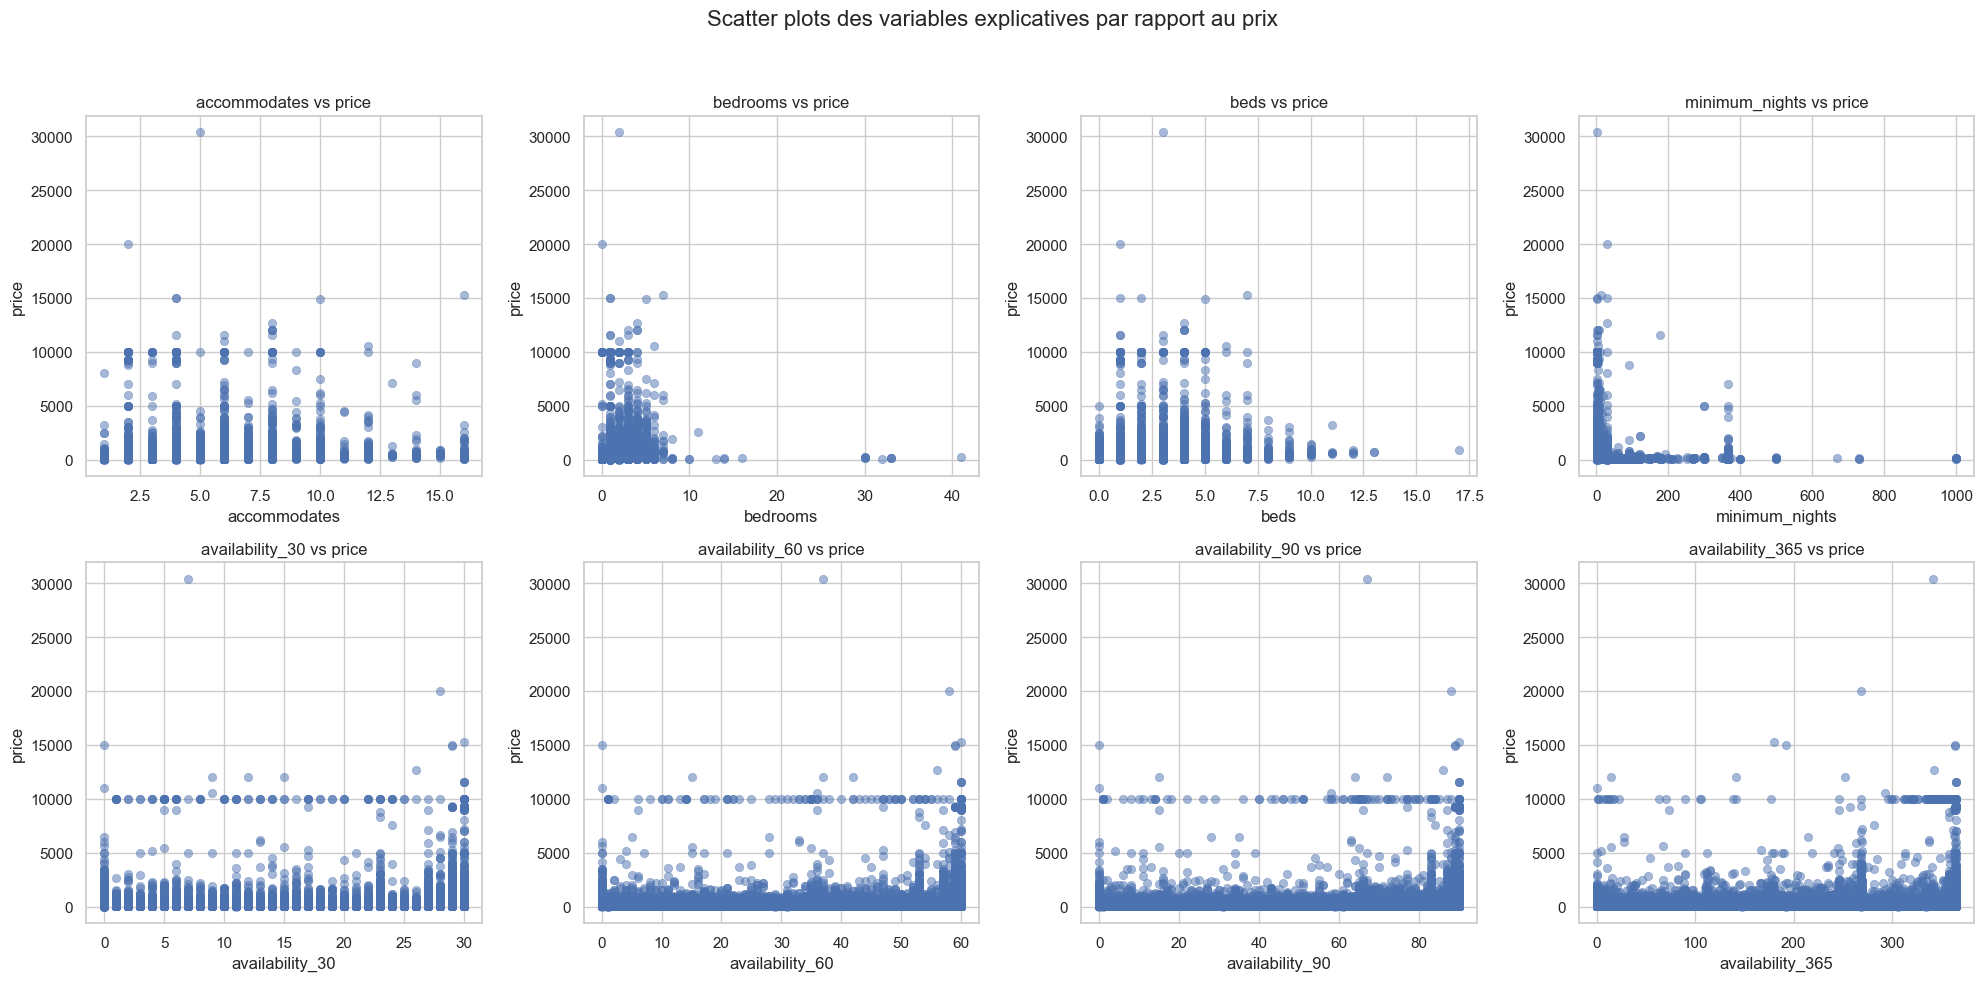

In [34]:
x = ['accommodates', 'bedrooms', 'beds', 'minimum_nights',
     'availability_30', 'availability_60', 'availability_90', 'availability_365']
y = 'price'


sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Scatter plots des variables explicatives par rapport au prix", fontsize=16)

variables = ['accommodates', 'bedrooms', 'beds', 'minimum_nights',
             'availability_30', 'availability_60', 'availability_90', 'availability_365']

for i, var in enumerate(variables):
    row, col = divmod(i, 4)
    ax = axes[row, col]
    sns.scatterplot(data=df_listing.toPandas(), x=var, y='price', ax=ax, alpha=0.5, edgecolor=None)
    ax.set_title(f"{var} vs price")
    ax.set_xlabel(var)
    ax.set_ylabel("price")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [77]:
dfc.sort_values(by="correlation_with_price", ascending=False).head(15)


,features,correlation_with_price
24,price,1.000000
76,price_euro,1.000000
5,accommodates,0.210530
7,beds,0.207438
6,bedrooms,0.188347
14,availability_365,0.134584
13,availability_90,0.123301
12,availability_60,0.122533
11,availability_30,0.119052
0,row_id,0.077087


In [28]:
dft = df_listing.toPandas()[["neighbourhood_cleansed", "review_scores_rating"]].copy()

result = dft.groupby("neighbourhood_cleansed").filter(lambda x: len(x) > 500) \
            .groupby("neighbourhood_cleansed") \
            .mean() \
            .reset_index() \
            .sort_values("review_scores_rating", ascending=False)

result

,neighbourhood_cleansed,review_scores_rating
9,Ménilmontant,4.779570
2,Buttes-Chaumont,4.772828
3,Buttes-Montmartre,4.765025
15,Popincourt,4.763547
12,Palais-Bourbon,4.759933
4,Entrepôt,4.755297
11,Opéra,4.752096
5,Gobelins,4.751462
16,Reuilly,4.750326
14,Passy,4.750221


In [29]:
dft = df_listing.toPandas()[["neighbourhood_cleansed", "review_scores_rating"]].copy()


result = dft.groupby("neighbourhood_cleansed").filter(lambda x: len(x) > 500) \
            .groupby("neighbourhood_cleansed") \
            .mean() \
            .reset_index() \
            .sort_values("review_scores_rating", ascending=False)

result

,neighbourhood_cleansed,review_scores_rating
9,Ménilmontant,4.779570
2,Buttes-Chaumont,4.772828
3,Buttes-Montmartre,4.765025
15,Popincourt,4.763547
12,Palais-Bourbon,4.759933
4,Entrepôt,4.755297
11,Opéra,4.752096
5,Gobelins,4.751462
16,Reuilly,4.750326
14,Passy,4.750221


## Combined pipeline for both numerical and categorical features

In [69]:
from pyspark.sql.functions import log1p
from pyspark.sql.functions import col

decimal_cols = [
    'bedrooms', 'beds', 'reviews_per_month',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value','host_response_rate'
]

for col_name in decimal_cols:
    df_listing = df_listing.withColumn(col_name, col(col_name).cast("double"))
    
df_listing = df_listing.filter((col("price") <= 1000) & (col("bedrooms") <= 10))
    
df_listing = df_listing.withColumn("log_price", log1p(col("price")))

df_listing = df_listing.withColumn(
    "accommodates_per_room", col("accommodates") / (col("bedrooms") + 1)
).withColumn(
    "beds_per_person", col("beds") / (col("accommodates") + 1)
).withColumn(
    "availability_ratio_30_365", col("availability_30") / (col("availability_365") + 1)
).withColumn(
    "minimum_nights_capped", when(col("minimum_nights") > 30, 30).otherwise(col("minimum_nights"))
)


In [78]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StandardScaler,
    StringIndexer, OneHotEncoder
)


numerical_attribs = ['accommodates', 'bedrooms', 'beds', 'minimum_nights',
                     'availability_30', 'availability_60', 'availability_90','availability_365'
                     'review_scores_rating','amenity_dishwasher', 'host_response_rate','accommodates_per_room','beds_per_person','amenity_bathtub',
                     'availability_ratio_30_365','minimum_nights_capped']

categorical_attribs = ["neighbourhood_cleansed",
                       "property_type", "room_type", "host_response_time"]


indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_attribs]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_attribs]


num_assembler = VectorAssembler(
    inputCols=numerical_attribs,
    outputCol="numerical_features"
)

scaler = StandardScaler(
    inputCol="numerical_features",
    outputCol="scaled_numerical_features"
)


assembler_inputs = [col + "_vec" for col in categorical_attribs] + ["scaled_numerical_features"]
final_assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features"
)


preprocessing_pipeline = Pipeline(stages=indexers + encoders + [num_assembler, scaler, final_assembler])


pipeline_model = preprocessing_pipeline.fit(df_listing)
df_prepared = pipeline_model.transform(df_listing)


IllegalArgumentException: availability_365review_scores_rating does not exist. Available: neighbourhood_cleansed, room_type, row_id, host_has_profile, host_verifications, host_is_superhost, host_since, host_response_time, host_response_rate, calculated_host_listings_count, property_type, accommodates, bedrooms, beds, minimum_nights, maximum_nights, has_availability, availability_30, availability_60, availability_90, availability_365, number_of_reviews, reviews_per_month, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, amenities, price, host_since_days, amenity_kitchen, amenity_wifi, amenity_smoke_alarm, amenity_essentials, amenity_hot_water, amenity_hair_dryer, amenity_iron, amenity_washer, amenity_dishes_and_silverware, amenity_hangers, amenity_bed_linens, amenity_cooking_basics, amenity_refrigerator, amenity_heating, amenity_tv, amenity_microwave, amenity_shampoo, amenity_hot_water_kettle, amenity_dedicated_workspace, amenity_cleaning_products, amenity_wine_glasses, amenity_oven, amenity_baking_sheet, amenity_toaster, amenity_dishwasher, amenity_freezer, amenity_shower_gel, amenity_dining_table, amenity_coffee_maker, amenity_elevator, amenity_drying_rack_for_clothing, amenity_body_soap, amenity_coffee, amenity_carbon_monoxide_alarm, amenity_extra_pillows_and_blankets, amenity_self_check_in, amenity_long_term_stays_allowed, amenity_room_darkening_shades, amenity_host_greets_you, amenity_stove, amenity_books_and_reading_material, amenity_bathtub, amenity_lockbox, amenity_portable_fans, amenity_laundromat_nearby, amenity_first_aid_kit, amenity_clothing_storage, amenity_central_heating, amenity_private_entrance, amenity_luggage_dropoff_allowed, price_euro, log_price, accommodates_per_room, beds_per_person, availability_ratio_30_365, minimum_nights_capped, neighbourhood_cleansed_index, property_type_index, room_type_index, host_response_time_index, neighbourhood_cleansed_vec, property_type_vec, room_type_vec, host_response_time_vec

In [58]:
df_prepared.show(5)

+----------------------+-----------+------+----------------+------------------+-----------------+----------+------------------+------------------+------------------------------+--------------------+------------+--------+----+--------------+--------------+----------------+---------------+---------------+---------------+----------------+-----------------+-----------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+--------------------+-----+---------------+---------------+------------+-------------------+------------------+-----------------+------------------+------------+--------------+-----------------------------+---------------+------------------+----------------------+--------------------+---------------+----------+-----------------+---------------+------------------------+---------------------------+-------------------------+--------------

In [ ]:
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)

In [60]:
train_data.select('log_price').show(5)

+-----------------+
|        log_price|
+-----------------+
|6.315358001522335|
| 4.59511985013459|
| 4.59511985013459|
| 4.59511985013459|
|5.993961427306569|
+-----------------+
only showing top 5 rows



In [79]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator


evaluator_rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")

evaluator_r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")

# Initialiser les modèles
rf = RandomForestRegressor(featuresCol="features", labelCol="log_price")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="log_price")
lr = LinearRegression(featuresCol="features", labelCol="log_price")

# ParamGridBuilder pour la recherche d'hyperparamètres
param_grid_rf = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [100, 200])
                 .addGrid(rf.maxDepth, [10, 20])
                 .build())

param_grid_dt = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [10, 20])
                 .addGrid(dt.minInstancesPerNode, [1, 5])
                 .build())

param_grid_lr = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.8, 0.9])
                 .build())

In [ ]:

# Définir CrossValidator pour chaque modèle
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator_rmse, numFolds=3)
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=param_grid_dt, evaluator=evaluator_rmse, numFolds=3)
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator_rmse, numFolds=3)


# Entraîner les modèles avec la validation croisée
model_rf = cv_rf.fit(train_data)
model_dt = cv_dt.fit(train_data)
model_lr = cv_lr.fit(train_data)

# Évaluation sur le jeu de test
predictions_rf = model_rf.transform(test_data)
predictions_dt = model_dt.transform(test_data)
predictions_lr = model_lr.transform(test_data)

rmse_rf = evaluator_rmse.evaluate(predictions_rf)
rmse_dt = evaluator_rmse.evaluate(predictions_dt)
rmse_lr = evaluator_rmse.evaluate(predictions_lr)


r2_rf = evaluator_r2.evaluate(predictions_rf)
r2_dt = evaluator_r2.evaluate(predictions_dt)
r2_lr = evaluator_r2.evaluate(predictions_lr)

2025-05-02 00:02:37,714 INFO: Closing down clientserver connection
2025-05-02 00:02:37,730 INFO: Closing down clientserver connection
2025-05-02 00:04:11,758 INFO: Closing down clientserver connection
2025-05-02 00:04:11,760 INFO: Closing down clientserver connection
2025-05-02 00:04:49,954 INFO: Closing down clientserver connection
2025-05-02 00:04:49,956 INFO: Closing down clientserver connection


In [52]:
print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")
print(f"Decision Tree → RMSE: {rmse_dt:.2f}, R²: {r2_dt:.2f}")
print(f"Linear Regression → RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")

Random Forest → RMSE: 390.07, R²: 0.21
Decision Tree → RMSE: 396.65, R²: 0.18
Linear Regression → RMSE: 423.18, R²: 0.07


In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")
train_sample = train_data.sample(fraction=0.1, seed=42)



def make_cv(model, param_grid):
    return CrossValidator(
        estimator=Pipeline(stages=[model]),
        estimatorParamMaps=param_grid,
        evaluator=evaluator_rmse,
        numFolds=3,
        seed=42
    )
    
# 🌳 Decision Tree
dt = DecisionTreeRegressor(labelCol="log_price", featuresCol="features")
param_dt = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).build()
cv_dt = make_cv(dt, param_dt)
model_dt = cv_dt.fit(train_sample)

# 🌲 Random Forest
rf = RandomForestRegressor(labelCol="log_price", featuresCol="features")
param_rf = ParamGridBuilder().addGrid(rf.numTrees, [20, 50]).addGrid(rf.maxDepth, [5, 10]).build()
cv_rf = make_cv(rf, param_rf)
model_rf = cv_rf.fit(train_sample)

# 🔥 GBT
gbt = GBTRegressor(labelCol="log_price", featuresCol="features")
param_gbt = ParamGridBuilder().addGrid(gbt.maxIter, [20, 50]).addGrid(gbt.maxDepth, [5, 10]).build()
cv_gbt = make_cv(gbt, param_gbt)
model_gbt = cv_gbt.fit(train_sample)

resultat = {}  


def eval_model(model, name):
    predictions = model.transform(test_data)
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    result[name] = {"RMSE": rmse, "R2":r2}
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}")

eval_model(model_dt.bestModel, "Decision Tree")
eval_model(model_rf.bestModel, "Random Forest")
eval_model(model_gbt.bestModel, "GBT")

2025-05-02 02:47:43,987 INFO: Closing down clientserver connection
2025-05-02 02:47:44,022 INFO: Closing down clientserver connection
2025-05-02 02:59:16,984 INFO: Closing down clientserver connection
2025-05-02 02:59:17,002 INFO: Closing down clientserver connection
2025-05-02 04:38:54,627 INFO: Closing down clientserver connection
2025-05-02 04:38:54,630 INFO: Closing down clientserver connection


Decision Tree - RMSE: 424.71, R2: 0.03
Random Forest - RMSE: 420.33, R2: 0.05
GBT - RMSE: 476.55, R2: -0.19


In [98]:
dt = DecisionTreeRegressor(labelCol="log_price", featuresCol="features")
param_dt = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).build()
cv_dt = make_cv(dt, param_dt)
model_dt = cv_dt.fit(train_data)

2025-05-02 13:20:30,088 INFO: Closing down clientserver connection
2025-05-02 13:20:30,091 INFO: Closing down clientserver connection


In [ ]:
predictions_dt = model_dt.transform(test_data)

rmse_dt = evaluator_rmse.evaluate(predictions_dt)
r2_dt = evaluator_r2.evaluate(predictions_dt)

print(f"Décision tree → RMSE: {rmse_dt:.2f}, R²: {r2_dt:.2f}")

In [80]:
rf = RandomForestRegressor(labelCol="log_price", featuresCol="features")
model_rf = rf.fit(train_data)

In [ ]:
predictions_rf = model_rf.transform(test_data)

rmse_rf = evaluator_rmse.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest → RMSE: 0.40, R²: 0.46


In [82]:
gbt = GBTRegressor(labelCol="log_price", featuresCol="features")
model_gbt = gbt.fit(train_data)

In [83]:
predictions_gbt = model_gbt.transform(test_data)

rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)

print(f"Random Forest → RMSE: {rmse_gbt:.2f}, R²: {r2_gbt:.2f}")

Random Forest → RMSE: 0.35, R²: 0.59


In [93]:
from xgboost.spark import SparkXGBRegressor
xgb_regressor = SparkXGBRegressor(
  features_col="features",
  label_col="log_price",
  num_workers=2,
)

model_xbst = xgb_regressor.fit(train_data)

2025-05-02 12:57:37,508 INFO: Running xgboost-3.0.0 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-05-02 12:58:03,624 INFO: Finished xgboost training!


In [95]:
predictions_xbst = model_xbst.transform(test_data)

rmse_xbst = evaluator_rmse.evaluate(predictions_xbst)
r2_xbst = evaluator_r2.evaluate(predictions_xbst)

print(f"Random Forest → RMSE: {rmse_xbst:.2f}, R²: {r2_xbst:.2f}")

Random Forest → RMSE: 0.31, R²: 0.67


## Application auto feature enginering

In [ ]:
from autofeat import AutoFeatRegressor
from pyspark.sql.functions import col
import pandas as pd

sample_pd = df_listing.select(
    ["price"] + numerical_attribs + categorical_attribs
).sample(fraction=0.3, seed=42).toPandas()

sample_pd = sample_pd.dropna()



In [ ]:
# Cible log transformée
sample_pd["log_price"] = np.log1p(sample_pd["price"])

# Encodage simple des catégorielles pour AutoFeat
sample_pd = pd.get_dummies(sample_pd, columns=categorical_attribs)

# Séparation features / target
X = sample_pd.drop(columns=["price", "log_price"])
y = sample_pd["log_price"]

# Application AutoFeat
model_af = AutoFeatRegressor(verbose=1, featsel_runs=1)

X_train_feat = model_af.fit_transform(X, y)

print("Nombre de nouvelles features générées :", X_train_feat.shape[1])

# Puis modèle ML classique
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X_train_feat, y, test_size=0.2, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))
